In [1]:
import os
import omegaconf
from shell.utils.experiment_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [4]:
# save_root_dir = "vanilla_results_wo_replacement"
save_root_dir = "finding_hyper_for_mod_contrastive"
dataset = "cifar100"
algo = "modular"
seed = 0
num_train=256
use_contrastive = True
# use_contrastive = False

In [5]:
job_name = f"{dataset}_{algo}_numtrain_{num_train}"
if use_contrastive:
    job_name += "_contrastive"
experiment = os.path.join(save_root_dir, job_name, dataset,algo, f"seed_{seed}")
config_path = os.path.join(experiment, "hydra_out", ".hydra", "config.yaml")
# read the config file
cfg = omegaconf.OmegaConf.load(config_path)
cfg

{'train': {'component_update_freq': 400, 'num_epochs': 400, 'save_freq': 20}, 'dataset': {'dataset_name': 'cifar100', 'num_tasks': 4, 'num_classes_per_task': 5, 'with_replacement': False, 'num_trains_per_class': 256, 'num_vals_per_class': -1, 'remap_labels': True}, 'net': {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'cifar100_modular_numtrain_256_contrastive', 'num_agents': 1, 'root_save_dir': 'finding_hyper_for_mod_contrastive', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}

In [6]:
graph, datasets, NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg = setup_experiment(cfg)
len(datasets)

{'train': {'component_update_freq': 400, 'num_epochs': 400, 'save_freq': 20}, 'dataset': {'dataset_name': 'cifar100', 'num_tasks': 4, 'num_classes_per_task': 5, 'with_replacement': False, 'num_trains_per_class': 256, 'num_vals_per_class': -1, 'remap_labels': True}, 'net': {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'cifar100_modular_numtrain_256_contrastive', 'num_agents': 1, 'root_save_dir': 'finding_hyper_for_mod_contrastive', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}
without replacement!! [97 66 33 19 34  3 12  2 13 92 80  5 27 60 36 11  9 25 31 87 58 44 94 95
 64 61 62 86 79 98 93 51 22 59 26 37 83 73 78  1 30 55 85 4

1

In [7]:
agent_id = 0
task_id = 19
task_id = 3
# num_added_components = 15
# num_added_components = 13
num_added_components = None

net = load_net(cfg, NetCls, net_cfg, agent_id=agent_id, task_id=task_id, num_added_components=num_added_components)
net

CNNSoftLLDynamic(
  (structure): ParameterList(
      (0): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (2): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (3): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
  )
  (softmax): Softmax(dim=0)
  (components): ModuleList(
    (0-3): 4 x Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): ModuleList(
    (0-3): 4 x Linear(in_features=200, out_features=5, bias=True)
  )
  (transform): Normalize(mean=(0.5079, 0.4872, 0.4415), std=(0.2676, 0.2567, 0.2765))
  (projector): Sequential(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=200, out_features=128, bias=True)
  )
)

In [8]:
dataset = datasets[agent_id]
testloaders = {task: torch.utils.data.DataLoader(testset,
                                                         batch_size=128,
                                                         shuffle=False,
                                                         num_workers=0,
                                                         pin_memory=True,
                                                         ) for task, testset in enumerate(dataset.testset[:(task_id+1)])}

In [9]:
acc = {}
with torch.no_grad():
    for task_id, testloader in testloaders.items():
        correct = 0.
        n = 0.
        for X, y in testloader:
            X = X.to(net.device)
            y = y.to(net.device)
            Y_hat = net(X, task_id)
            correct += (Y_hat.argmax(dim=1) == y).sum().item()
            n += len(y)
        acc[task_id] = correct / n

acc["avg"] = np.mean(list(acc.values()))
acc

{0: 0.646, 1: 0.768, 2: 0.746, 3: 0.672, 'avg': 0.7080000000000001}

In [10]:
l = [len(test.dataset) for test in testloaders.values()]
print(l)
print(len(l))

[500, 500, 500, 500]
4


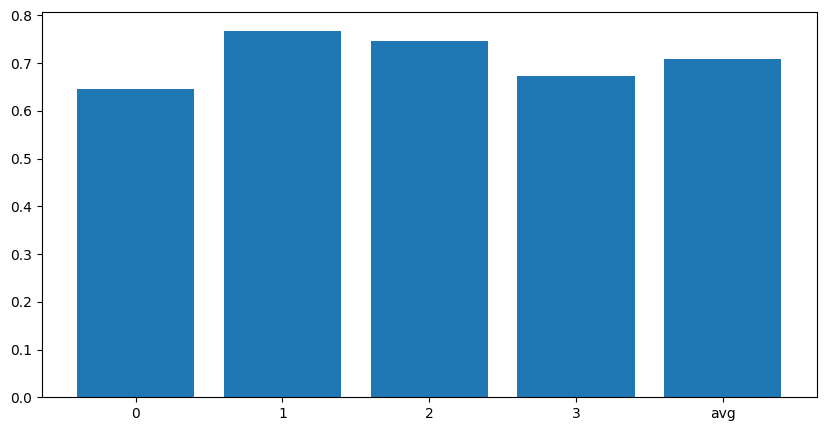

In [11]:
# plot acc as bar chart, note that x-axis contains "avg" as well
# convert all keys to str
acc = {str(k): v for k, v in acc.items()}
plt.figure(figsize=(10, 5))
plt.bar(acc.keys(), acc.values());

In [12]:
X_out = [] # features
y_out = [] # global labels
y_task = [] # globallabel_task_id
with torch.no_grad():
    for task_id, testloader in testloaders.items():
        for X, y in testloader:
            X = X.to(net.device)
            if use_contrastive:
                X_encode = net.contrastive_embedding(X, task_id)
            else:
                X_encode = net.encode(X, task_id)
            X_out.append(X_encode.cpu())
            y_out.append(y.cpu())
            y_task.append(np.ones_like(y) * task_id)
X_encode = np.concatenate(X_out, axis=0)
Y = np.concatenate(y_out, axis=0)
y_task = np.concatenate(y_task, axis=0)

In [13]:
X_encode.shape

(2000, 128)

In [14]:
X_embedded = TSNE(n_components=2, random_state=0, init="pca", n_jobs=-1).fit_transform(X_encode)

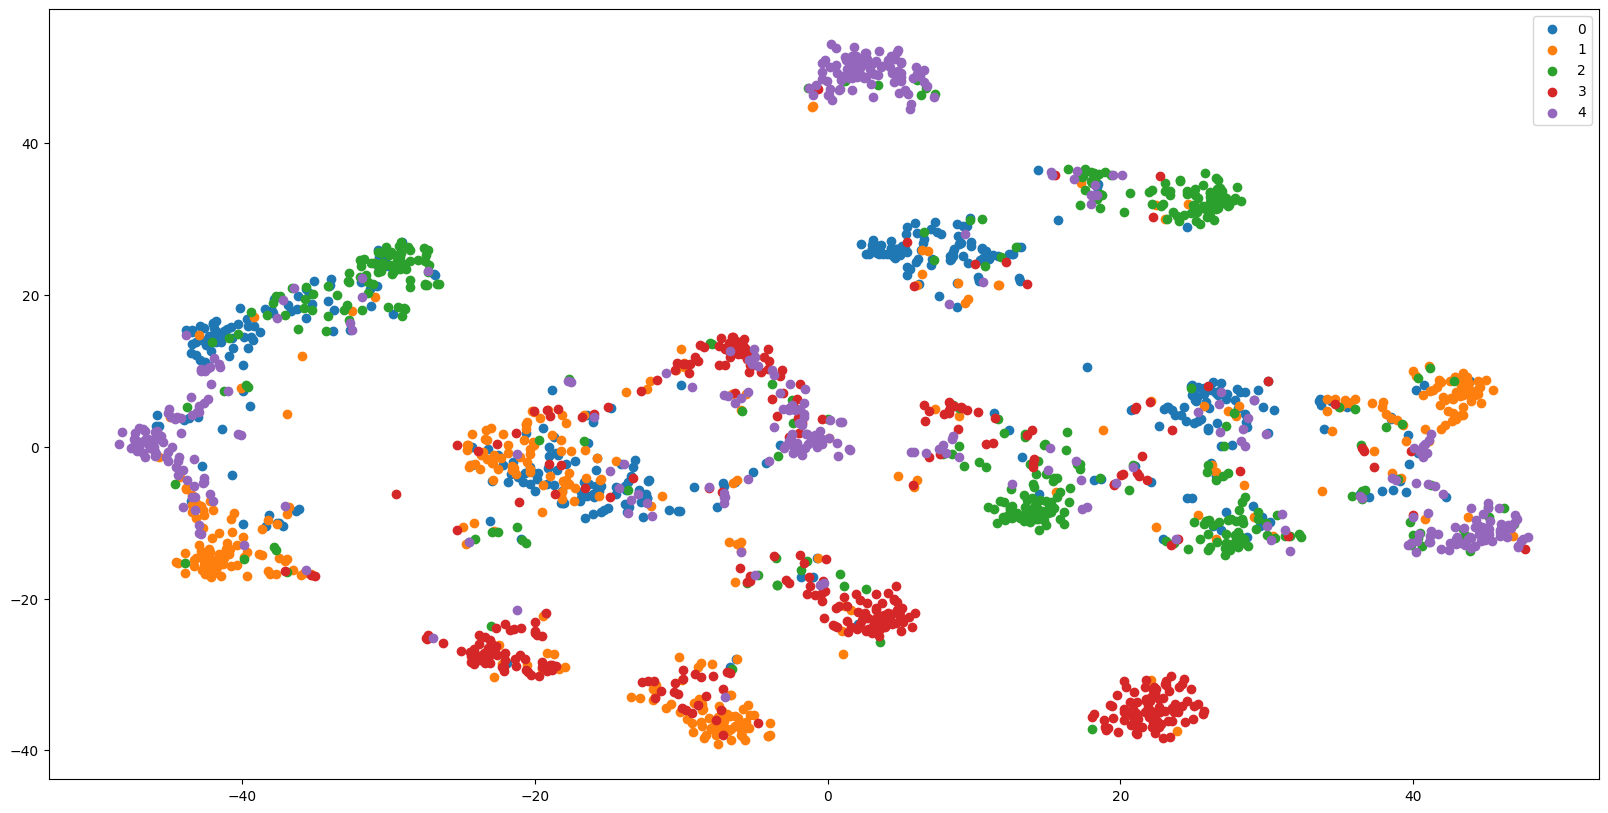

In [15]:
plt.figure(figsize=(20,10))

for y_label in np.unique(Y):
    plt.scatter(X_embedded[Y == y_label, 0], X_embedded[Y == y_label, 1], label=y_label)

plt.legend();

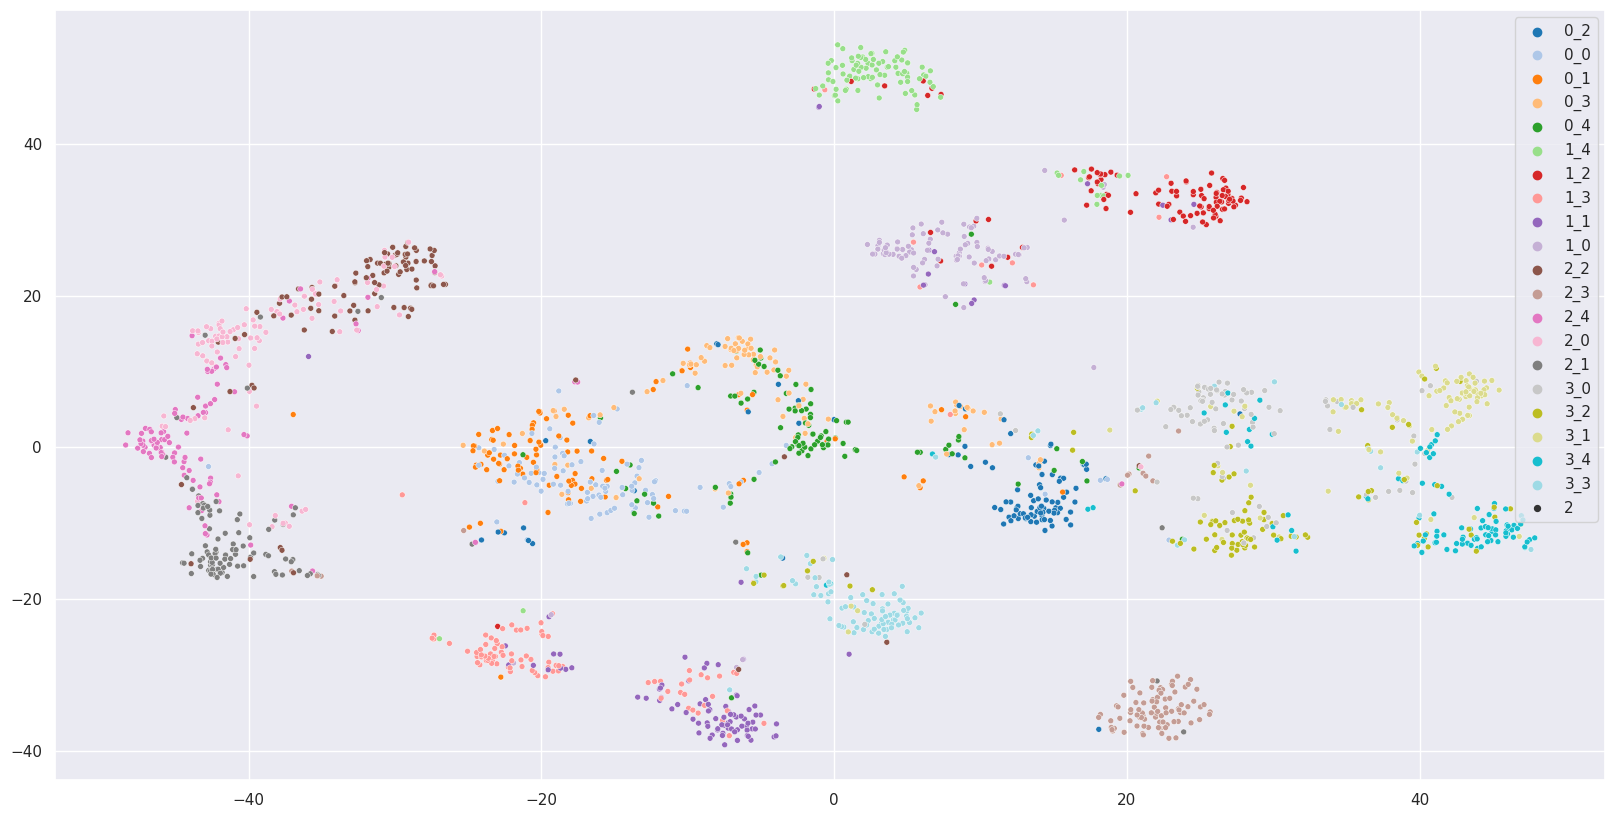

In [16]:
# create an array same size as y and y_task where each element is {y}_{y_task} string
# y_task_str = np.array([str(Y[i]) + "_" + str(y_task[i]) for i in range(len(Y))]) # class_task
y_task_str = np.array([str(y_task[i]) + "_" + str(Y[i]) for i in range(len(Y))]) # task_class
# plot X_embedded with color corresponding to y_task_str
import seaborn as sns
# different sns color palette
# bigger plot size
sns.set(rc={'figure.figsize':(20,10)})
sns.set_palette("tab20")
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_task_str, size=2);